Copy of other ML notebook with new dataset

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import scipy.stats
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.neighbors
import sklearn.ensemble
import sklearn.feature_selection
import unittest

Things I've tried to improve model: 

1. drop bit scores over 1000
2. Switch to 85/15 train/test split
3. Lasso regression - not great
4. Ridge regression - R2 = 0.87, about the same as normal Linear regression
5. KNN regression (n_neighbors optimized at 8) gives best result, R2 = ~0.93 --> 
*got it up to .942 by removing a few features
6. Decision tree regressor was slightly worse than KNN


In [2]:
cd /Users/loganroberts/Learn2Therm/ValidProt/data

/Users/loganroberts/Learn2Therm/ValidProt/data


In [3]:
#convert to pandas df
df_original = pd.read_csv('learn2therm_sample_50k/learn2therm_sample_50k.csv')

In [4]:
df_original.head()

,Unnamed: 0,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,thermo_index,...,bit_score_16s,m_ogt,t_ogt,ogt_difference,m_protein_seq,t_protein_seq,m_protein_desc,t_protein_desc,m_protein_len,t_protein_len
0,0,0.287582,0.217822,0.215686,160,0.792079,152,0.737864,131,875,...,1153.0,27.5,50.0,22.5,MAESGTSRRADHLVPVPGPDAEPPAVADELLRAVGRGDEQAFGRLY...,MPSQITESERIELAERFERDALPLLDQLYSAALRMTRNPADAEDLV...,ECF RNA polymerase sigma factor SigK,sigma-70 family RNA polymerase sigma factor,206,202
1,1,0.319635,0.295359,0.297872,218,0.919831,226,0.969957,282,11324,...,1014.0,25.0,54.0,29.0,MARIALVDDDRNILTSVSMTLEAEGFEVETYNDGQSALDAFNKRMP...,MRVLLVEDDPNTSRSIEMMLTHANLNVYATDMGEEGIDLAKLYDYD...,response regulator transcription factor,response regulator transcription factor,233,237
2,2,0.279621,0.234127,0.218924,211,0.837302,210,0.731707,96,875,...,1138.0,28.0,50.0,22.0,MKDTVVFVTGAARGIGAHTARLAVARGARVALVGLEPHLLADLAAE...,MTPEQIFSGQTAIVTGGASGIGAATVEHIARRGGRVFSVDLSYDSP...,SDR family oxidoreductase,SDR family oxidoreductase,287,252
3,3,0.327273,0.200743,0.214712,166,0.617100,163,0.696581,175,875,...,1077.0,28.0,50.0,22.0,MTSGLWERVLDGVWVTIQLLVLSALLATAVSFVVGIARTHRLWIVR...,MAMSRRKRGQLARGIQYAILVIVVVVLALLADWGKIGKAFFDWEAA...,ectoine/hydroxyectoine ABC transporter permeas...,amino acid ABC transporter permease,234,269
4,4,0.338710,0.318182,0.287671,60,0.909091,71,0.887500,61,9827,...,991.0,30.0,50.0,20.0,MIISLRRGLRFIRFIVFFAALVYLFYHVLDLFNGWISPVDQYQMPT...,MKRMVWRTLKVFIIFIACTLLFYFGLRFMHLEYEQFHRYEPPEGPA...,YqzK family protein,YqzK family protein,80,66


In [5]:
#get rid of stuff that isn't quantitative

df = df_original.drop(columns = ['Unnamed: 0','thermo_index', 'm_protein_seq', 't_protein_seq',
                        'm_protein_desc', 't_protein_desc'])

In [6]:
df.head()

,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,meso_index,prot_pair_index,...,scaled_local_query_percent_id_16s,scaled_local_symmetric_percent_id_16s,query_align_cov_16s,subject_align_cov_16s,bit_score_16s,m_ogt,t_ogt,ogt_difference,m_protein_len,t_protein_len
0,0.287582,0.217822,0.215686,160,0.792079,152,0.737864,131,12897,48641291,...,0.921620,0.926461,0.998040,0.998020,1153.0,27.5,50.0,22.5,206,202
1,0.319635,0.295359,0.297872,218,0.919831,226,0.969957,282,13026,92992745,...,0.900068,0.902522,1.000000,1.000000,1014.0,25.0,54.0,29.0,233,237
2,0.279621,0.234127,0.218924,211,0.837302,210,0.731707,96,8203,157628663,...,0.919007,0.923531,1.000000,1.000000,1138.0,28.0,50.0,22.0,287,252
3,0.327273,0.200743,0.214712,166,0.617100,163,0.696581,175,3340,136708305,...,0.908556,0.909745,0.996734,0.996726,1077.0,28.0,50.0,22.0,234,269
4,0.338710,0.318182,0.287671,60,0.909091,71,0.887500,61,14020,133672542,...,0.883142,0.887107,0.998084,0.998067,991.0,30.0,50.0,20.0,80,66


from pairplot below, it looks like query_align_cov_16s and subject_align_cov_16s dont correlate with anything

In [7]:
# sns.pairplot(df.sample(500),height = 4)

#i dont see much higher-order correlation, so it's likely we can use linear regression

In [8]:
df = df.drop(columns = ['query_align_cov_16s', 'subject_align_cov_16s'])

In [9]:
df.describe()

,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,meso_index,prot_pair_index,...,taxa_pair_index,local_gap_compressed_percent_id_16s,scaled_local_query_percent_id_16s,scaled_local_symmetric_percent_id_16s,bit_score_16s,m_ogt,t_ogt,ogt_difference,m_protein_len,t_protein_len
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,5.000000e+04,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.349026,0.276478,0.270792,206.011660,0.791507,205.414920,0.770875,230.63206,8098.858120,9.105934e+07,...,362827.905140,0.906828,0.903266,0.904959,1061.404480,27.348365,51.505410,24.157045,269.985200,261.367700
std,0.096608,0.114404,0.116039,64.260901,0.144893,64.430548,0.179955,186.44859,4608.982941,5.233883e+07,...,229264.926253,0.015240,0.015626,0.015300,75.659661,3.737201,3.816972,3.586797,65.935753,69.675548
min,0.164103,0.081301,0.045977,19.000000,0.284553,19.000000,0.082019,35.00000,5.000000,1.219000e+03,...,4885.000000,0.876590,0.836055,0.880026,891.000000,7.000000,41.000000,20.000000,30.000000,27.000000
25%,0.293750,0.204545,0.202020,172.000000,0.673288,172.000000,0.656854,118.00000,4121.000000,4.645832e+07,...,173976.750000,0.895995,0.893020,0.893531,1009.000000,27.000000,50.000000,22.000000,233.000000,226.000000
50%,0.325000,0.250000,0.244648,210.000000,0.811321,209.000000,0.806584,186.00000,8046.000000,9.160212e+07,...,312362.000000,0.905983,0.902326,0.903543,1056.000000,28.000000,52.500000,24.500000,267.000000,260.000000
75%,0.367257,0.308300,0.301639,240.000000,0.923077,240.000000,0.923077,267.00000,12103.000000,1.360713e+08,...,617814.000000,0.916172,0.912576,0.914698,1108.000000,29.000000,52.500000,24.500000,317.000000,311.000000
max,0.985075,0.985075,0.985075,400.000000,1.000000,399.000000,1.000000,1788.00000,16564.000000,1.814866e+08,...,744518.000000,0.999351,0.993544,0.996439,1679.000000,40.000000,78.000000,56.000000,400.000000,400.000000


Text(0, 0.5, 'Count')

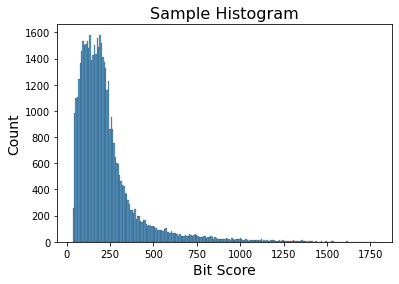

In [10]:
#plot empirical distribution of scaled_local_query_percent_id

target = df['bit_score']
#create histplot
fig, ax = plt.subplots()

sns.histplot(data = df, x = target)

ax.set_title('Sample Histogram', fontsize=16)
ax.set_xlabel('Bit Score', fontsize=14)
ax.set_ylabel('Count', fontsize=14)

In [11]:
print('The mean is: {} and the standard deviation is: {}.'.format(target.mean(),target.std())) 

print('The minimum bit score is: {} and the maximum bit score is: {}.'.format(target.min(),target.max()))

The mean is: 230.63206 and the standard deviation is: 186.4485895406217.
The minimum bit score is: 35 and the maximum bit score is: 1788.


1) Split dev and test data:

In [12]:
#see if there is a linear correlation between feature and target

pearson_corr = df_original.corr(method = 'pearson')['bit_score']

pearson_corr.abs() < 0.1

<ipython-input-12-b8ac4588c83c>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  pearson_corr = df_original.corr(method = 'pearson')['bit_score']


Unnamed: 0                                True
local_gap_compressed_percent_id          False
scaled_local_query_percent_id            False
scaled_local_symmetric_percent_id        False
query_align_len                          False
query_align_cov                          False
subject_align_len                        False
subject_align_cov                        False
bit_score                                False
thermo_index                              True
meso_index                                True
prot_pair_index                           True
meso_protein_int_index                    True
thermo_protein_int_index                  True
taxa_pair_index                           True
local_gap_compressed_percent_id_16s       True
scaled_local_query_percent_id_16s         True
scaled_local_symmetric_percent_id_16s     True
query_align_cov_16s                       True
subject_align_cov_16s                     True
bit_score_16s                             True
m_ogt        

In [13]:
#lets remove some stuff with low pearson correlation. We're gonna keep meso and thermo ogt for now <-- NVM

df = df.drop(columns = ['meso_index', 'meso_protein_int_index', 'local_gap_compressed_percent_id_16s', 
                        'scaled_local_query_percent_id_16s', 'scaled_local_symmetric_percent_id_16s',
                       'bit_score_16s', 'm_ogt', 't_ogt', 'taxa_pair_index', 'thermo_protein_int_index'
                       , 'prot_pair_index', 'ogt_difference'])

In [14]:
#choosing 80/20 split instead of 85/15 because of volume of data

dev, test = sklearn.model_selection.train_test_split(df, test_size=0.15, random_state=1)

print(dev.shape)
print(test.shape)

(42500, 10)
(7500, 10)


In [15]:
input_features = [columns for columns in df]
input_features.remove('bit_score')
input_features

['local_gap_compressed_percent_id',
 'scaled_local_query_percent_id',
 'scaled_local_symmetric_percent_id',
 'query_align_len',
 'query_align_cov',
 'subject_align_len',
 'subject_align_cov',
 'm_protein_len',
 't_protein_len']

In [16]:
target_feature = 'bit_score'

In [17]:
#predicting values 

dev_X = dev[input_features].values
test_X = test[input_features].values

dev_y = dev[target_feature].values.reshape(-1,1)
test_y = test[target_feature].values.reshape(-1,1)  

print(dev_X.shape, test_X.shape, dev_y.shape, test_y.shape)

(42500, 9) (7500, 9) (42500, 1) (7500, 1)


2) Scale the data

In [18]:
scaler = sklearn.preprocessing.StandardScaler()
dev_X = scaler.fit_transform(dev_X)
test_X = scaler.fit_transform(test_X)

3) Regularize the data -L1 or L2? Read online

4. Train the model

In [19]:
#KNN gives a better fit

model = sklearn.neighbors.KNeighborsRegressor(n_neighbors=10)
model.fit(dev_X, dev_y)

KNeighborsRegressor(n_neighbors=10)

5. Test the model, report MSE and MAE

In [20]:
R2 = model.score(test_X, test_y)
print('R2 score is: {}'.format(R2))

preds = model.predict(test_X)
preds[0:10]

R2 score is: 0.9419240911144752


array([[187.4],
       [233.3],
       [220.3],
       [121.2],
       [148. ],
       [156.6],
       [412.1],
       [ 73.2],
       [228.3],
       [313.2]])

y = 0.932x + 16.911
R2 = 0.9419


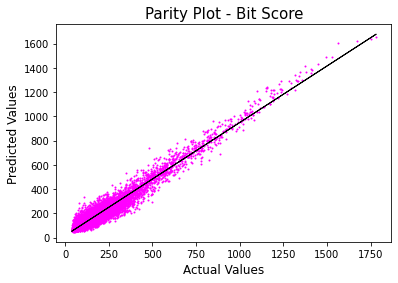

In [21]:
# make a plot to show the fit
fig, ax = plt.subplots()

# plot the actual vs. predicted values
ax.scatter(test_y, preds, c='magenta',s=1, label='Parity Plot')
plt.xlabel("Actual Values", fontsize=12)
plt.ylabel("Predicted Values", fontsize=12)
plt.title('Parity Plot - Bit Score', fontsize=15)

#plot line of best fit
slope, intercept = np.polyfit(np.ravel(test_y), preds, 1)
plt.plot(np.ravel(test_y), slope*np.ravel(test_y) + intercept, c='black', lw=1)
print('y = {}x + {}'.format(round(float(slope),4), round(float(intercept),4)))
print('R2 = {}'.format(round(R2,4)))

#add mean squared error 

In [22]:
mae = sklearn.metrics.mean_absolute_error(test_y, preds)
rmse = sklearn.metrics.mean_squared_error(test_y, preds, squared=False)
relative_std = (scipy.stats.variation(target, axis=0))

print("The MAE is : {} and the MSE is: {}".format(round(mae,4), round(rmse,4)))

print("The mean bit score is: {} and the standard deviation is: {}.".format(target.mean(),target.std())) 

print("The relative std. deviation is: {}.".format(round(relative_std, 4)))

The MAE is : 34.4435 and the MSE is: 44.9996
The mean bit score is: 230.63206 and the standard deviation is: 186.4485895406217.
The relative std. deviation is: 0.8084.


Make stuff from above into functions.

In [23]:
def split_data(dataframe):
    """
    Takesdataframe and splits it into dev and test sets.
    
    Params
    ----------
    dataframe: Pandas dataframe 

    Returns
    -------
    -Dev and test data
    
    """
    
    #test input data type
    if "pandas.core.frame.DataFrame" not in str(type(dataframe)):
        raise ValueError("Wrong input type!")
    else:
        pass
    
    #split data
    dev, test = sklearn.model_selection.train_test_split(dataframe, test_size=0.15, random_state=1)
    
    return dev, test

In [24]:
class TestDataSplit(unittest.TestCase):
    
    def test_data_split_input(self):
    
        #test that input data type is correct
        
        try:
            split_data([1,2,3])
            self.assertTrue(False)
        except ValueError:
            self.assertTrue(True)
    
    def test_data_split_output(self):
    
        #test that output data type is correct
        
        if "tuple" in str(type(split_data(df))):
            self.assertTrue(True)
        else:
            self.assertTrue(False)

            
#why only running one test?
suite = unittest.TestLoader().loadTestsFromTestCase(TestDataSplit)
_ = unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 0.009s

OK


In [25]:
def train_reg(dev, test, columns = [],  target = []):
    """
    Takes dev and test dataframes and trains a standard Linear Regression model with selected data.
    
    Params
    ----------
    dev, test: Pandas dataframe previously split
    columns: list of strings, representing input features
    target: list of strings, representing target feature(s)

    Returns
    -------
    -Pearson correlation between each input and the output feature
    -Linear regression model
    -input test data vector (numpy array)
    -feature test vector (numpy array)
    """
    
    #test input arguments
    assert "pandas.core.frame.DataFrame" in str(type(dev))
    assert "pandas.core.frame.DataFrame" in str(type(test))
    assert "str" in str(type(columns[0]))
    assert "str" in str(type(target[0]))
    assert columns[0] in dev
    assert target in test
   
    #split into input and output feature(s)
    dev_X = dev[columns].values
    test_X = test[columns].values

    dev_y = dev[target].values.reshape(-1,1)
    test_y = test[target].values.reshape(-1,1)
    
    #return pearson correlation for linear correlation
    pearson_corr = dev.corr(method = 'pearson')[target]
    
    #scale data
    scaler = sklearn.preprocessing.StandardScaler()
    dev_X = scaler.fit_transform(dev_X)
    test_X = scaler.fit_transform(test_X)
    
    #train model
    model = sklearn.neighbors.KNeighborsRegressor(n_neighbors=10)
    model = model.fit(dev_X, dev_y)
    
    return pearson_corr, model, test_X, test_y
    

In [26]:
p_corr, model, test_X, test_y = train_reg(split_data(df)[0], split_data(df)[1], columns = input_features, 
                                          target = target_feature)

For training test, check that train and test data follow similar distribution. (Bootstrap).

In [27]:
#JSD, from L4 notebook

def JSD_dev_and_test(data_sample_1, data_sample_2, axis=None):
    """Jensen-Shannon divergence between two data samples.
    
    Formatted for use with scipy bootstrapping. Creates a vector of values covering
    the data range, the fits scipy historgram PDFs to both data samples. Each PDF is
    evaluated at the vector of values, and those PDF values are used to compute
    JSD. Note that becaue the empirical distribution is a histogram, JSD will rarely
    be less than about ~0.1 due to discretization artifacts.
    
    Parameters
    ----------
    data_sample_1 : numpy array or pandas series
        observations in sample 1
    data_sample_2 : numpy array or pandas series
        observations in sample 2
    axis : ignored
    
    Returns
    -------
    float : Value of JSD
    """
    # get the min and max values to compute PDF
    global_minimum = min([data_sample_1.min(), data_sample_2.min()])
    global_maximum = min([data_sample_1.max(), data_sample_2.max()])
    width = global_maximum - global_minimum
    
    x = np.linspace(global_minimum - 0.1*width, global_maximum + 0.1*width, 1000)
    
    # create empirical PDFs for the samples
    s1_distro = scipy.stats.rv_histogram(np.histogram(data_sample_1))
    s2_distro = scipy.stats.rv_histogram(np.histogram(data_sample_2))
    
    # compute JSD
    JSD = scipy.spatial.distance.jensenshannon(s1_distro.pdf(x), s2_distro.pdf(x))
    return [JSD]

In [28]:
#cite Evan

JSD = (scipy.stats.bootstrap(
    (split_data(df)),
    JSD_dev_and_test,
    n_resamples=1000,
    batch=5,
    method='percentile'
))

In [29]:
#test code-need to update

class TestModelTraining(unittest.TestCase):
    
    def test_invalid_inputs(self):
    
        #test that input data type is correct
        
        try:
            train_reg([1,2,3], [4,5,6], columns = 'string', target = 'string')
            self.assertTrue(False)
        except AssertionError:
            self.assertTrue(True)
    
    def test_input_distro(self):
        
        #test that dev and test data have similar distribution via Jensen Shannon Distribution
        
        JSD = (
            scipy.stats.bootstrap((split_data(df)), 
                                  JSD_dev_and_test, n_resamples=1000, 
                                  batch=5, method='percentile')
        )

        div = JSD.confidence_interval[1]
        
        #asserts that the divergence between data sets is sufficiently low
        assert abs(div) < 0.3, "Warning! High JSD between dev and test set!"
        
    def test_output_format(self):
        
        #asserts that function returns 4 objects to be assigned to pearson_corr, model, test_X, test_y
        assert len(train_reg(split_data(df)[0], split_data(df)[1], columns = input_features, 
                                          target = target_feature)) == 4
        

suite = unittest.TestLoader().loadTestsFromTestCase(TestModelTraining)
_ = unittest.TextTestRunner().run(suite)

...
----------------------------------------------------------------------
Ran 3 tests in 10.435s

OK


Should ask Dave for more info about specific unit test formats.

Write an accuracy test. Maybe move the pearson correlation to a unit test to ensure that all variables are valuable to the model.

In [30]:
def test_reg(model, test_X, test_y):
    
    """
    Takes a trained model and test data and tests the model.
    
    Params
    ----------
    model: sklearn.linear_model
    test_X: numpy array
    test_y: numpy array

    Returns
    -------
    -Vector of predictions based on the model (numpy array)
    -prints R2 score of the model
    -prints mean absolute error and mean squared error from model
    -prints mean, standard deviation, and relative standard deviation for the target feature
    """
    
    #test input arguments
    assert "sklearn" in str(type(model))
    assert "numpy.ndarray" in str(type(test_X))
    assert "numpy.ndarray" in str(type(test_y))
    
    R2 = model.score(test_X, test_y)
    
    print('R2 score is: {}'.format(round(R2,4)))
    
    preds = model.predict(test_X)

    mae = sklearn.metrics.mean_absolute_error(test_y, preds)
    rmse = sklearn.metrics.mean_squared_error(test_y, preds, squared=False)
    
    mae = sklearn.metrics.mean_absolute_error(test_y, preds)
    rmse = sklearn.metrics.mean_squared_error(test_y, preds, squared=False)
    relative_std = (scipy.stats.variation(target, axis=0))

    print("The MAE is: {} and the MSE is: {}".format(round(mae,4), round(rmse,4)))

    print("The mean bit score is: {} and the standard deviation is: {}.".format(target.mean(),target.std())) 

    print("The relative std. deviation is: {}.".format(round(relative_std, 4)))
    
    return preds

In [31]:
preds = test_reg(model, test_X, test_y)
preds

R2 score is: 0.9419
The MAE is: 34.4435 and the MSE is: 44.9996
The mean bit score is: 230.63206 and the standard deviation is: 186.4485895406217.
The relative std. deviation is: 0.8084.


array([[187.4],
       [233.3],
       [220.3],
       ...,
       [131.5],
       [321.4],
       [167.9]])

A good test here can be adding outliers and seeing how much the score and predictions change (probably for the above function).

In [32]:
def plot_regression(model, test_X, test_y):
    """
    Takes a test Linear Regression ML model and plots the predictions against actual values.
    
    Params
    ----------
    model: sklearn.linear_model
    test_X: numpy array
    test_y: numpy array

    Returns
    -------
    -Parity plot of predictions vs. observations
    -Equation of line of best fit (always linear)
    -R2 score
    """
    
    #test input arguments
    assert "sklearn" in str(type(model))
    assert "numpy.ndarray" in str(type(test_X))
    assert "numpy.ndarray" in str(type(test_y))
    
    R2 = model.score(test_X, test_y)
    preds = test_reg(model, test_X, test_y)
    
    # make a plot to show the fit
    fig, ax = plt.subplots()

    # plot the actual vs. predicted values
    ax.scatter(test_y, preds, c='magenta',s=1, label='Parity Plot')
    plt.xlabel("Actual Values", fontsize=12)
    plt.ylabel("Predicted Values", fontsize=12)
    plt.title('Parity Plot - Bit Score', fontsize=15)

    #plot line of best fit
    slope, intercept = np.polyfit(np.ravel(test_y), preds, 1)
    plt.plot(np.ravel(test_y), slope*np.ravel(test_y) + intercept, c='black', lw=1)
    print('y = {}x + {}'.format(round(float(slope),4), round(float(intercept),4)))
    print('R2 = {}'.format(round(R2,4)))

R2 score is: 0.9419
The MAE is: 34.4435 and the MSE is: 44.9996
The mean bit score is: 230.63206 and the standard deviation is: 186.4485895406217.
The relative std. deviation is: 0.8084.
y = 0.932x + 16.911
R2 = 0.9419


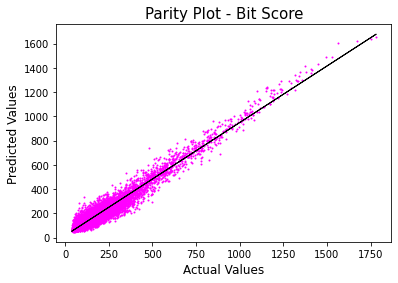

In [33]:
plot_regression(model, test_X, test_y)

THESE ARE OLDER FUNCTIONS. IF ABOVE FUNCTIONS WORK, CLEAN THESE OUT.

def train_reg(dataframe, columns = [],  target = []):
    """
    Takes a dataframe and trains a Linear Ridge (L2 regularization) Regression model with selected data.
    
    Params
    ----------
    dataframe: Pandas dataframe
    columns: list of strings, representing input features
    target: list of strings, representing target feature(s)

    Returns
    -------
    -Pearson correlation between each input and the output feature
    -Linear regression model
    -input test data vector (numpy array)
    -feature test vector (numpy array)
    """
    
    #split data
    dev, test = sklearn.model_selection.train_test_split(dataframe, test_size=0.20, random_state=1)
    
    #split into input and output feature(s)
    dev_X = dev[columns].values
    test_X = test[columns].values

    dev_y = dev[target].values.reshape(-1,1)
    test_y = test[target].values.reshape(-1,1)
    
    #return pearson correlation for linear correlation
    pearson_corr = dev.corr(method = 'pearson')[target]
    
    #scale data
    scaler = sklearn.preprocessing.StandardScaler()
    dev_X = scaler.fit_transform(dev_X)
    test_X = scaler.fit_transform(test_X)
    
    #train model
    model = sklearn.linear_model.Ridge()
    model = model.fit(dev_X, dev_y)
    
    return pearson_corr, model, test_X, test_y
    

p_corr, model, test_X, test_y = train_reg(df, columns = ['meso_ogt', 'thermo_ogt', 
                                                         'scaled_local_symmetric_percent_id',
                                                         'local_E_value','local_gap_compressed_percent_id'], 
                                          target = ['scaled_local_query_percent_id'])

#test code

def test_reg(model, test_X, test_y):
    
    """
    Takes a trained model and test data and tests the model.
    
    Params
    ----------
    model: sklearn.linear_model
    test_X: numpy array
    test_y: numpy array

    Returns
    -------
    -Vector of predictions based on the model (numpy array)
    -prints R2 score of the model
    -prints mean absolute error and mean squared error from model
    """
    
    R2 = model.score(test_X, test_y)
    
    print('R2 score is: {}'.format(R2))

    preds = model.predict(test_X)

    mae = sklearn.metrics.mean_absolute_error(test_y, preds)
    mse = sklearn.metrics.mean_squared_error(test_y, preds)

    print("The MAE is : {} and the MSE is: {}".format(round(mae,6), round(mse,6)))
    
    return preds

preds = test_reg(model, test_X, test_y)
preds

def plot_regression(model, test_X, test_y):
    """
    Takes a test Linear Regression ML model and plots the predictions against actual values.
    
    Params
    ----------
    model: sklearn.linear_model
    test_X: numpy array
    test_y: numpy array

    Returns
    -------
    -Parity plot of predictions vs. observations
    -Equation of line of best fit (always linear)
    -R2 score
    """
    preds = test_reg(model, test_X, test_y)
    
    # make a plot to show the fit
    fig, ax = plt.subplots()

    # plot the actual vs. predicted values
    ax.scatter(test_y, preds, c='b',s=6, label='Parity Plot')
    plt.xlabel("Actual Values", fontsize=12)
    plt.ylabel("Predicted Values", fontsize=12)
    plt.title('Parity Plot', fontsize=15)

    #plot line of best fit
    slope, intercept = np.polyfit(np.ravel(test_y), preds, 1)
    plt.plot(np.ravel(test_y), slope*np.ravel(test_y) + intercept, c='green', lw=1)
    print('y = {}x + {}'.format(round(float(slope),4), round(float(intercept),4)))
    print('R2 = {}'.format(round(R2,4)))